In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy import stats
import scipy as sp
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.simplefilter("ignore", category=ValueError)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")

In [2]:
sbux_clv=pd.read_csv('sbux_clv_with_viewed_completed_channel.csv')

In [3]:
sbux_clv.head()

,Customer ID,Age,Gender,HH Income,MemberSince,Recency (# Days ago from last trans. As of final day up to Day 15),Frequency (# Trans. from Day 1-15),Monetary Value (Sum of Trans. from Day 1-15),Avg. Order Value (AOV) from Day 1-15 (Monetary Value/Frequency),# of Marketing offers that Starbucks sent to each customer from Day 1-15,# of Marketing offers that were viewed from Day 1-15,# of Marketing offers that were successfully completed from Day 1-15,Marketing Offer View Rate from Day 1-15,Marketing Offer Response Rate from Day 1-15,Count of Completed offers using Email channel from Day 1-15,Count of Completed offers using Mobile channel from Day 1-15,Count of Completed offers using Social channel from Day 1-15,Count of Completed offers using Web channel from Day 1-15,Sum(Trans. Amt from Day 16-30)
0,0009655768c64bdeb2e877511632db8f,18-34,M,50k-75k,2017,5,1,22.16,22.16,2.0,1.0,NaN,0.50,0.00,NaN,NaN,NaN,NaN,105.44
1,00116118485d4dfda04fdbaba9a87b5c,Unknown,Unknown,Unknown,2018,2,1,0.70,0.70,1.0,1.0,NaN,1.00,0.00,NaN,NaN,NaN,NaN,3.39
2,0011e0d4e6b944f998e987f904e8c1e5,35-50,O,50k-75k,2018,4,2,25.42,12.71,3.0,3.0,1.0,1.00,0.33,1.0,1.0,1.0,1.0,54.04
3,0020c2b971eb4e9188eac86d93036a77,51-67,F,75k-100k,2016,8,4,98.33,24.58,3.0,1.0,1.0,0.33,0.33,1.0,1.0,1.0,1.0,98.53
4,0020ccbbb6d84e358d3414a3ff76cffd,18-34,F,50k-75k,2016,2,5,62.86,12.57,2.0,2.0,1.0,1.00,0.50,1.0,1.0,1.0,1.0,91.19


In [4]:
# Select only the numerical columns
numerical_cols = sbux_clv.select_dtypes(include='number')

#Are there any nulls in numerical columns?
for column in numerical_cols:
    if numerical_cols[column].isnull().any():
       print('{0} has {1} null values'.format(column, numerical_cols[column].isnull().sum()))

# of Marketing offers that Starbucks sent to each customer from Day 1-15 has 233 null values
# of Marketing offers that were viewed from Day 1-15 has 1582 null values
# of Marketing offers that were successfully completed from Day 1-15 has 6594 null values
Marketing Offer View Rate from Day 1-15 has 233 null values
Marketing Offer Response Rate from Day 1-15 has 233 null values
Count of Completed offers using Email channel from Day 1-15 has 6594 null values
Count of Completed offers using Mobile channel from Day 1-15 has 6594 null values
Count of Completed offers using Social channel from Day 1-15 has 6594 null values
Count of Completed offers using Web channel from Day 1-15 has 6594 null values
Sum(Trans. Amt from Day 16-30) has 221 null values


In [5]:
def impute_nulls_with_zero(df, columns_to_impute):
    """
    Imputes null values in specified columns with 0 in a DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns_to_impute (list): List of column names to impute null values with 0.
    
    Returns:
        pandas.DataFrame: DataFrame with null values replaced by 0 in specified columns.
    """
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    for column in columns_to_impute:
        df_copy[column].fillna(0, inplace=True)
    
    return df_copy

In [6]:
# List of columns with missing values to be imputed with 0
columns_to_impute = [
    '# of Marketing offers that Starbucks sent to each customer from Day 1-15',
    '# of Marketing offers that were viewed from Day 1-15',
    '# of Marketing offers that were successfully completed from Day 1-15',
    'Marketing Offer View Rate from Day 1-15',
    'Marketing Offer Response Rate from Day 1-15',
    'Count of Completed offers using Email channel from Day 1-15',
    'Count of Completed offers using Mobile channel from Day 1-15',
    'Count of Completed offers using Social channel from Day 1-15',
    'Count of Completed offers using Web channel from Day 1-15',
    'Sum(Trans. Amt from Day 16-30)'
]

# Call the function to impute nulls with 0
numerical_cols = impute_nulls_with_zero(numerical_cols, columns_to_impute)
numerical_cols

,MemberSince,Recency (# Days ago from last trans. As of final day up to Day 15),Frequency (# Trans. from Day 1-15),Monetary Value (Sum of Trans. from Day 1-15),Avg. Order Value (AOV) from Day 1-15 (Monetary Value/Frequency),# of Marketing offers that Starbucks sent to each customer from Day 1-15,# of Marketing offers that were viewed from Day 1-15,# of Marketing offers that were successfully completed from Day 1-15,Marketing Offer View Rate from Day 1-15,Marketing Offer Response Rate from Day 1-15,Count of Completed offers using Email channel from Day 1-15,Count of Completed offers using Mobile channel from Day 1-15,Count of Completed offers using Social channel from Day 1-15,Count of Completed offers using Web channel from Day 1-15,Sum(Trans. Amt from Day 16-30)
0,2017,5,1,22.16,22.16,2.0,1.0,0.0,0.50,0.00,0.0,0.0,0.0,0.0,105.44
1,2018,2,1,0.70,0.70,1.0,1.0,0.0,1.00,0.00,0.0,0.0,0.0,0.0,3.39
2,2018,4,2,25.42,12.71,3.0,3.0,1.0,1.00,0.33,1.0,1.0,1.0,1.0,54.04
3,2016,8,4,98.33,24.58,3.0,1.0,1.0,0.33,0.33,1.0,1.0,1.0,1.0,98.53
4,2016,2,5,62.86,12.57,2.0,2.0,1.0,1.00,0.50,1.0,1.0,1.0,1.0,91.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15037,2015,1,8,148.84,18.60,3.0,2.0,2.0,0.67,0.67,2.0,2.0,1.0,2.0,432.14
15038,2017,3,3,16.05,5.35,2.0,2.0,1.0,1.00,0.50,1.0,1.0,1.0,1.0,13.89
15039,2018,14,1,0.64,0.64,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.51
15040,2017,1,7,42.50,6.07,2.0,2.0,1.0,1.00,0.50,1.0,1.0,1.0,1.0,46.33


In [7]:
#After KNN imputer, are there any nulls in numerical columns?
for column in numerical_cols:
    if numerical_cols[column].isnull().any():
       print('{0} has {1} null values'.format(column, numerical_cols[column].isnull().sum()))

ValueError: Image size of 116263x522 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x576 with 1 Axes>

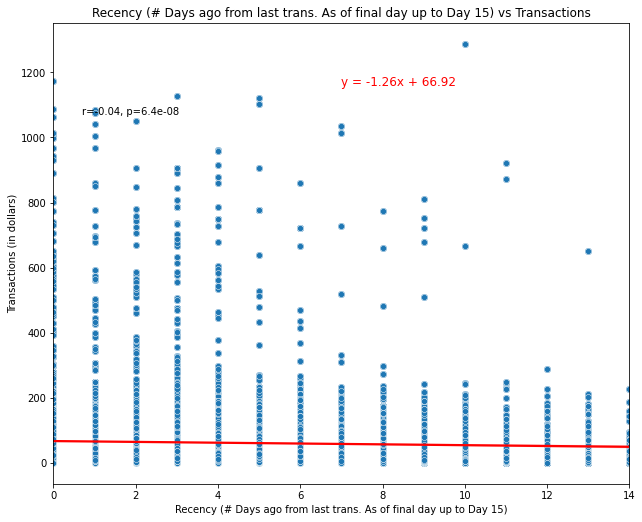

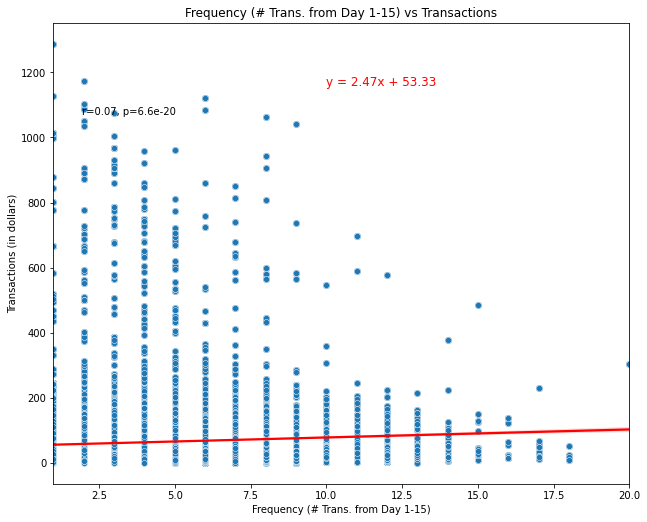

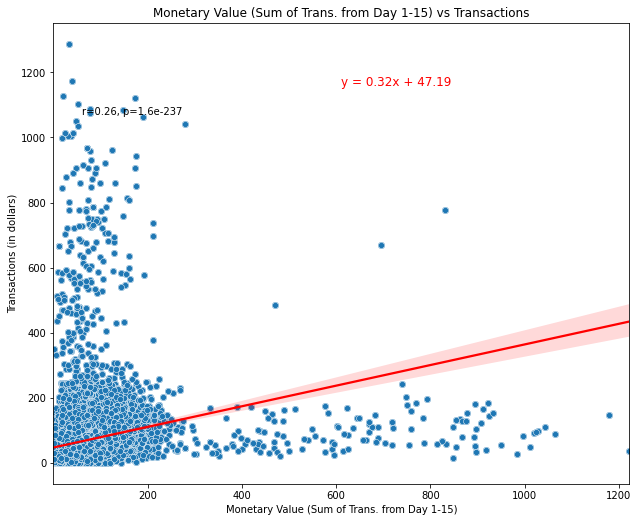

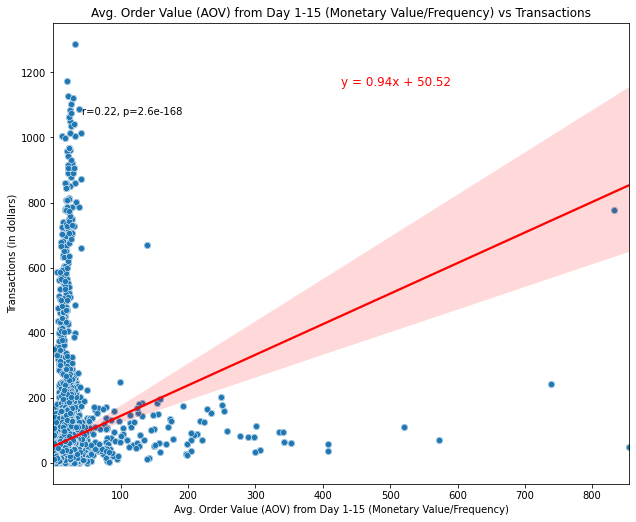

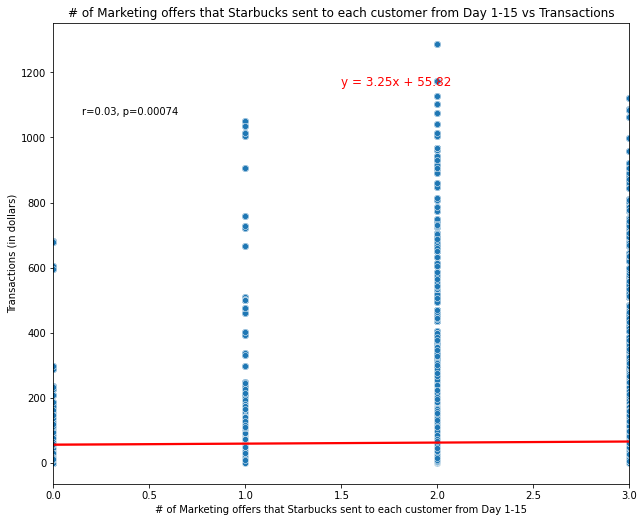

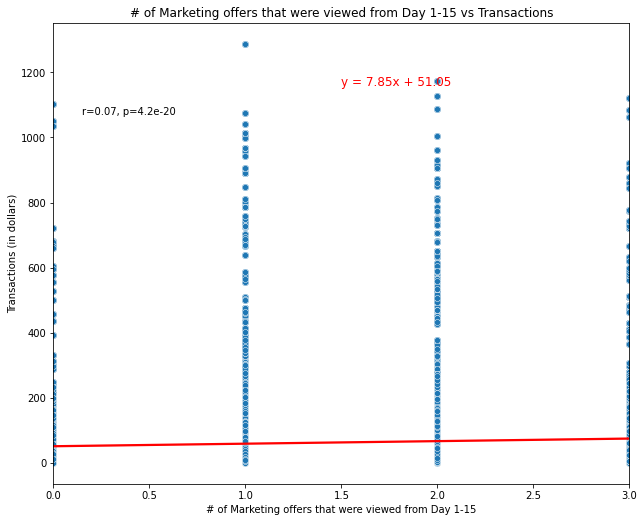

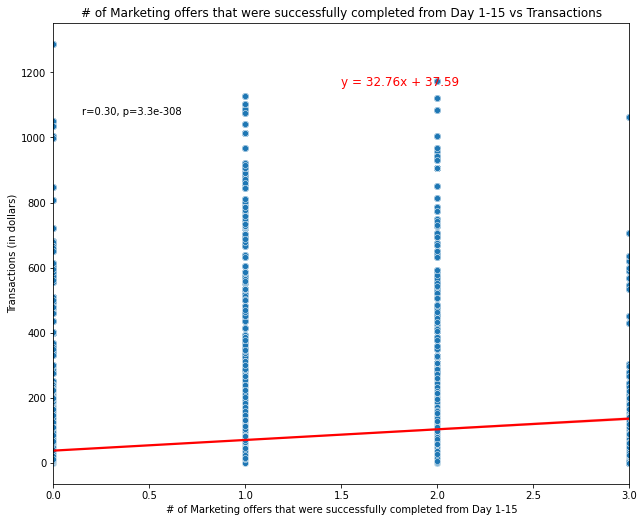

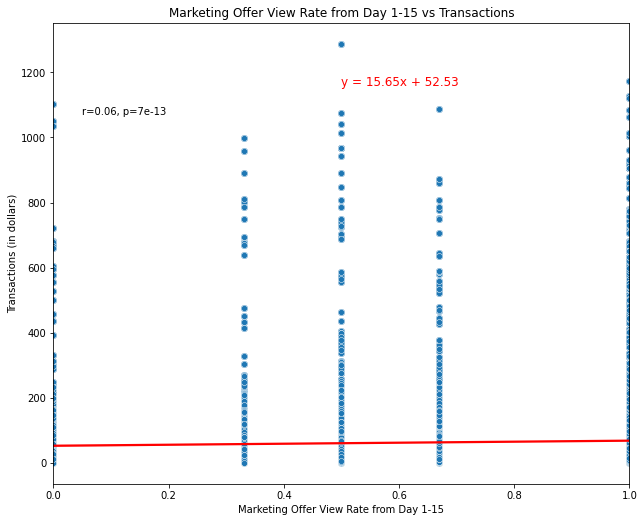

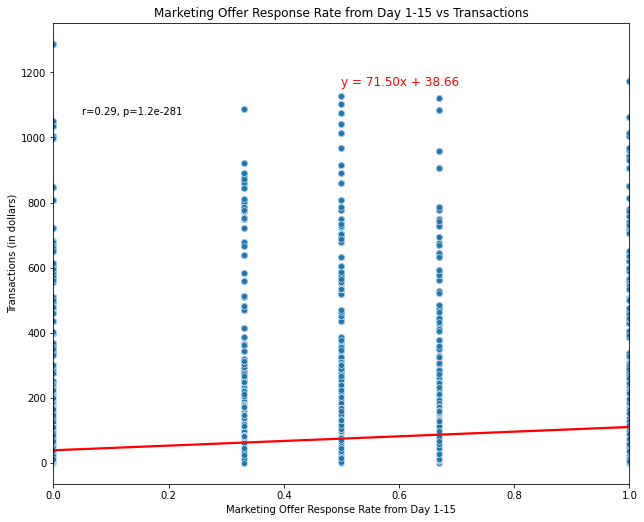

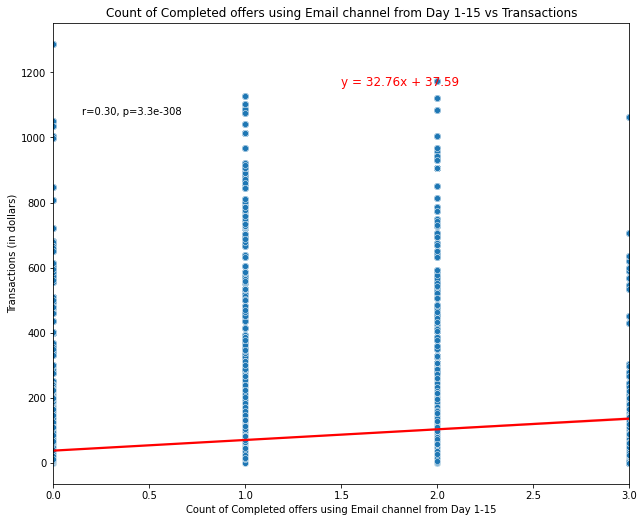

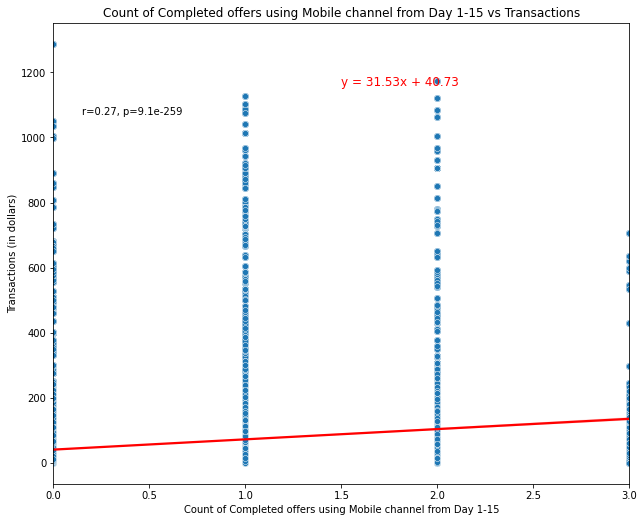

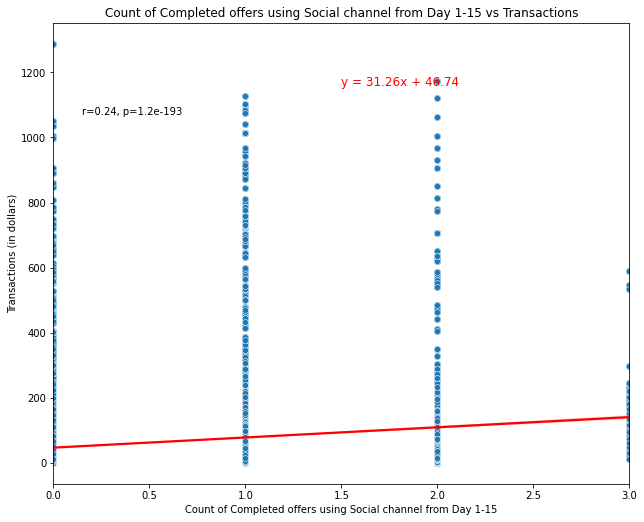

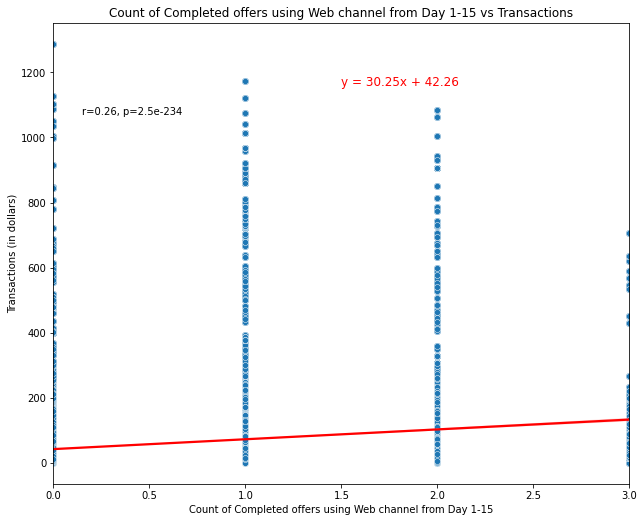

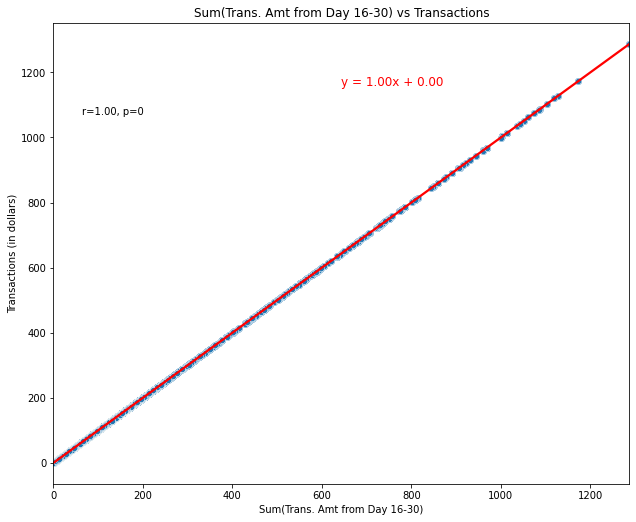

In [8]:
numerical_cols_list = numerical_cols.columns.tolist()

# Loop through each numerical column
for x in numerical_cols_list:
    try:
        # Calculate the linear regression statistics
        slope, intercept, r_value, p_value, std_err = stats.linregress(numerical_cols[x],numerical_cols['Sum(Trans. Amt from Day 16-30)'])
        
        # Plot the data
        fig, ax = plt.subplots(figsize=(10,8))
        sns.scatterplot(x=x, y='Sum(Trans. Amt from Day 16-30)',
                           data=numerical_cols, ax=ax)
        def annotate(data, **kws):
            r, p = sp.stats.pearsonr(numerical_cols[x],numerical_cols['Sum(Trans. Amt from Day 16-30)'])
            ax = plt.gca()
            ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
        annotate(None)
        
        # Plot the regression line
        ax = sns.regplot(x=x, y='Sum(Trans. Amt from Day 16-30)', data=numerical_cols, scatter_kws={"zorder":-1},
        line_kws={'color': 'red'})

        # Add the regression line label
        plt.text(x=numerical_cols[x].max()*0.5, y=numerical_cols['Sum(Trans. Amt from Day 16-30)'].max()*0.9,
                 s='y = {:.2f}x + {:.2f}'.format(slope, intercept),
                 color='red', fontsize=12)

        # Add the legend
        plt.title(str(x)+' vs Transactions')
        plt.xlabel(x)
        plt.ylabel("Transactions (in dollars)")

        # Adjust the plot margins
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

        plt.show()
        
    except Exception as e:
        print('Skipping feature', x, 'due to error:', e)

#Conclusion
#1.Monetary Value, 2.AOV, 3.# of offers that were completed,
#4.Marketing Offer Response Rate, 5. Count of completed offers by channel across all channels 
# may be important to predicting transactions in week 3+4 with Pearson R between .20-.30

In [9]:
# Select only the categorical columns
categorical_cols = sbux_clv.select_dtypes(include='object')

# Print the categorical columns
print(categorical_cols)

                            Customer ID      Age   Gender HH Income
0      0009655768c64bdeb2e877511632db8f    18-34        M   50k-75k
1      00116118485d4dfda04fdbaba9a87b5c  Unknown  Unknown   Unknown
2      0011e0d4e6b944f998e987f904e8c1e5    35-50        O   50k-75k
3      0020c2b971eb4e9188eac86d93036a77    51-67        F  75k-100k
4      0020ccbbb6d84e358d3414a3ff76cffd    18-34        F   50k-75k
...                                 ...      ...      ...       ...
15037  fff3ba4757bd42088c044ca26d73817a    68-84        F  75k-100k
15038  fff7576017104bcc8677a8d63322b5e1    68-84        M   50k-75k
15039  fff8957ea8b240a6b5e634b6ee8eafcf    68-84        M   50k-75k
15040  fffad4f4828548d1b5583907f2e9906b    18-34        M   30k-50k
15041  ffff82501cea40309d5fdd7edcca4a07    35-50        F   50k-75k

[15042 rows x 4 columns]


In [10]:
categorical_cols = sbux_clv[['Age', 'MemberSince']]

# Check for "Unknown" values in categorical columns
unknown_mask = categorical_cols.isin(['Unknown']).any(axis=1)

# Drop records with "Unknown" values
sbux_clv_no_unknown = sbux_clv[~unknown_mask]

unknown_records_exist = sbux_clv_no_unknown.isin(['Unknown']).any().any()
if unknown_records_exist:
    print("There are still Unknown records in the categorical columns.")
else:
    print("There are no Unknown records in the categorical columns.")


There are no Unknown records in the categorical columns.


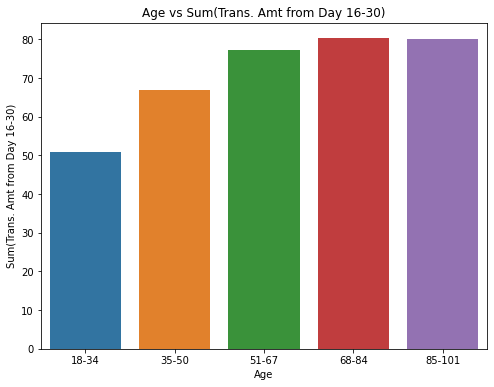

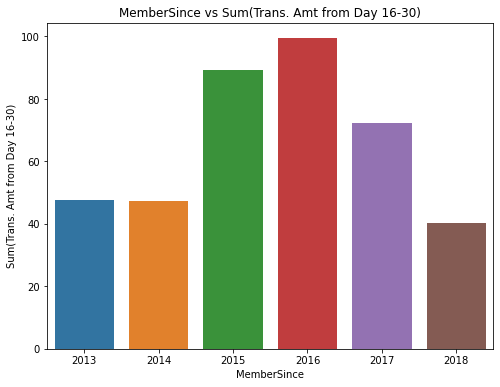

In [11]:
# Updated categorical columns after dropping unknown records
categorical_cols_no_unknown = sbux_clv_no_unknown[['Age','MemberSince']]

target_variable = sbux_clv['Sum(Trans. Amt from Day 16-30)']

for column in categorical_cols_no_unknown:
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=column, y=target_variable, data=categorical_cols_no_unknown, ci=None)
    ax.set_xlabel(column)
    ax.set_ylabel('Sum(Trans. Amt from Day 16-30)')
    ax.set_title(f'{column} vs Sum(Trans. Amt from Day 16-30)')

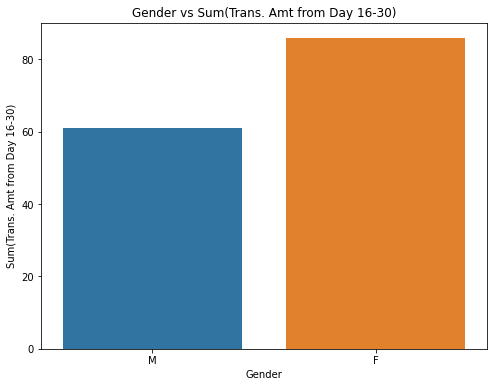

In [12]:
#Gender
target_variable = sbux_clv['Sum(Trans. Amt from Day 16-30)']

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Gender', y=target_variable, data=sbux_clv[(sbux_clv['Gender'] != 'Unknown') & (sbux_clv['Gender'] != 'O')], ci=None)
ax.set_xlabel('Gender')
ax.set_ylabel('Sum(Trans. Amt from Day 16-30)')
ax.set_title('Gender vs Sum(Trans. Amt from Day 16-30)')
plt.show()
#more females than males spent from Day 16-30.

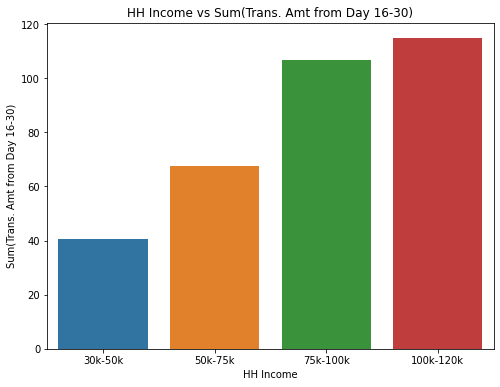

In [13]:
#HH Income
target_variable = sbux_clv['Sum(Trans. Amt from Day 16-30)']

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='HH Income', y=target_variable, data=sbux_clv[sbux_clv['HH Income'] != 'Unknown'], ci=None,
                order=['30k-50k', '50k-75k', '75k-100k', '100k-120k'])
ax.set_xlabel('HH Income')
ax.set_ylabel('Sum(Trans. Amt from Day 16-30)')
ax.set_title('HH Income vs Sum(Trans. Amt from Day 16-30)')
plt.show()
#The higher the household income, the propensity to spend more from Day 16-30.

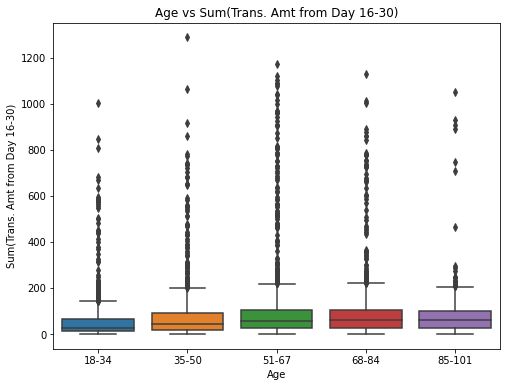

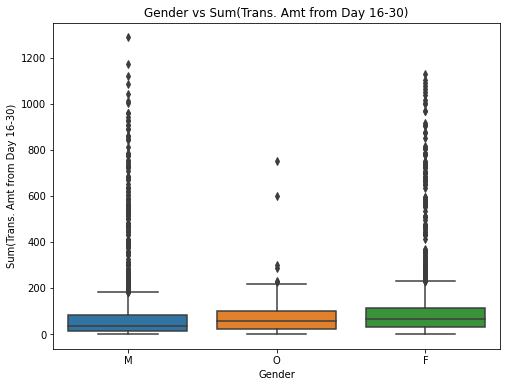

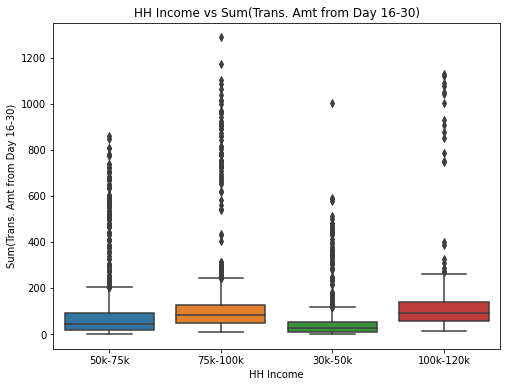

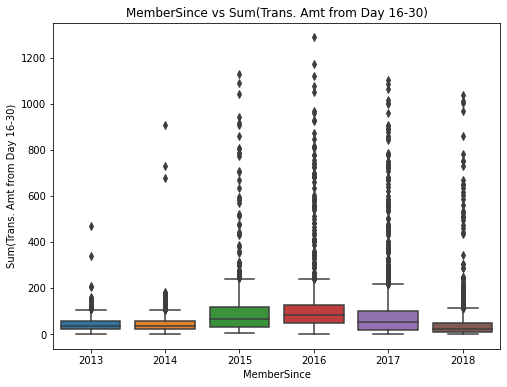

In [14]:
# Updated categorical columns after dropping unknown records
categorical_cols_no_unknown = sbux_clv_no_unknown[['Age', 'Gender', 'HH Income', 'MemberSince']]

target_variable = sbux_clv['Sum(Trans. Amt from Day 16-30)']

for column in categorical_cols_no_unknown:
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(x=column, y=target_variable, data=categorical_cols_no_unknown)
    ax.set_xlabel(column)
    ax.set_ylabel('Sum(Trans. Amt from Day 16-30)')
    ax.set_title(f'{column} vs Sum(Trans. Amt from Day 16-30)')
    plt.show()
#Lots of user outliers that spend alot more than the average person.

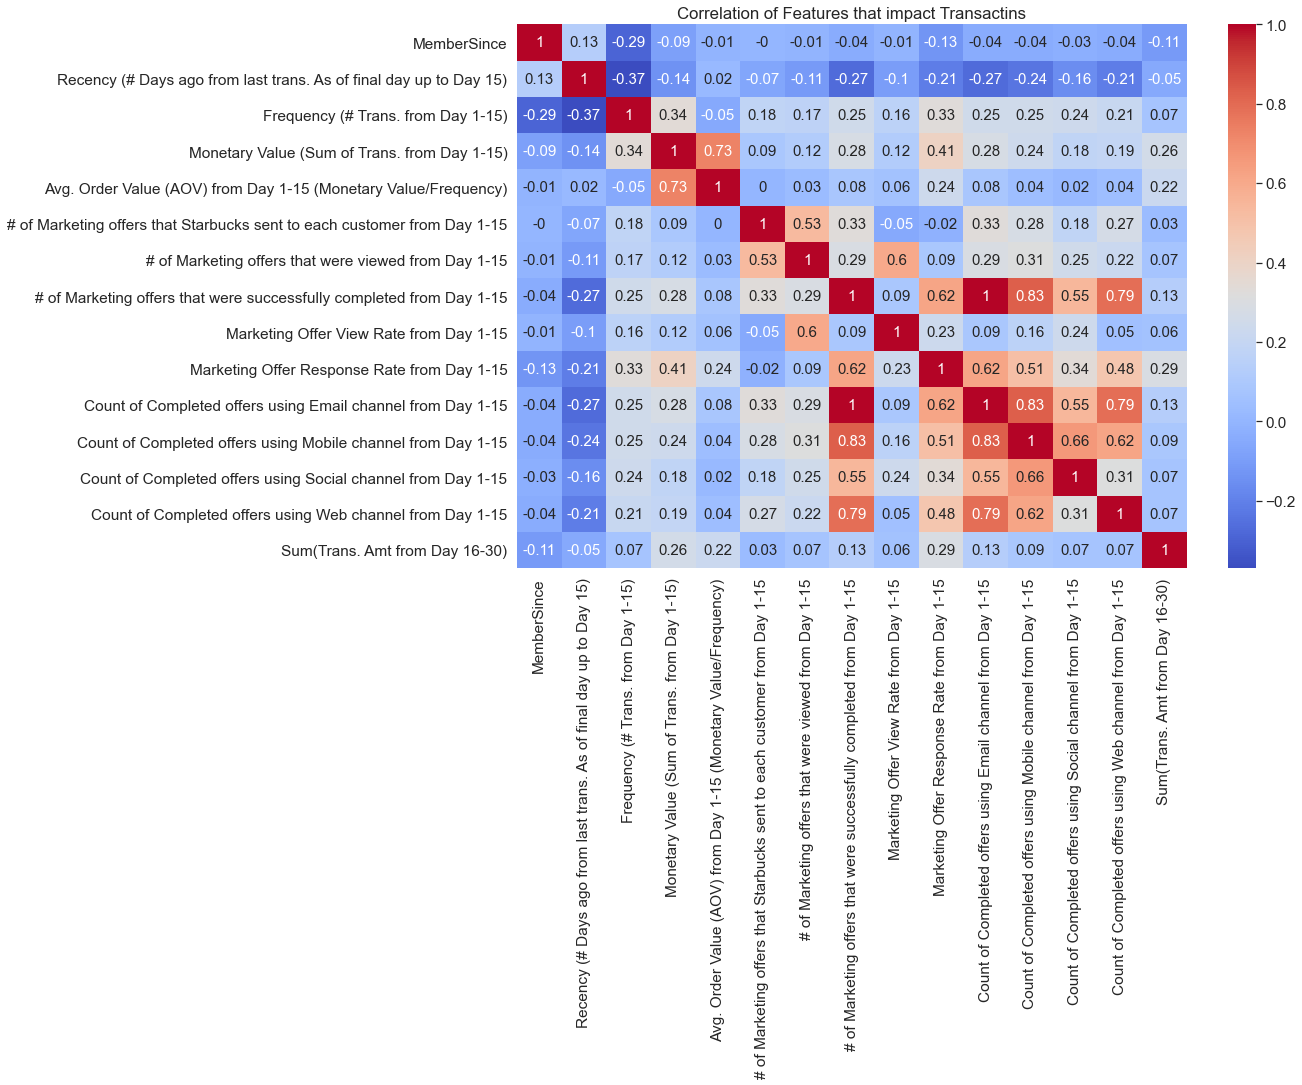

In [15]:
plt.figure(figsize = (15,10))
cormap = sbux_clv[numerical_cols_list].corr()
cormap=round(cormap,2)
sns.set(font_scale=1.4)
sns.heatmap(cormap, cmap='coolwarm', annot=True, annot_kws={"size":15})
plt.title('Correlation of Features that impact Transactins')
plt.show()
#the high correlations have similar derivations, they are multicollinear. 

In [16]:
numeric_features = numerical_cols
numeric_features_list = numeric_features.columns.tolist()

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_features_list
vif_data["VIF"] = [variance_inflation_factor(numeric_features.values, i) for i in range(len(numeric_features_list))]
vif_data = vif_data.drop(vif_data[vif_data['feature'] == 'Sum(Trans. Amt from Day 16-30)'].index)
vif_data.sort_values('VIF', ascending=False)
#They are multicullinear because they are feature engineered columns that are derived similarly. 
#Will drop AOV and Completed Offers across Channels.

,feature,VIF
7,# of Marketing offers that were successfully c...,inf
10,Count of Completed offers using Email channel ...,inf
6,# of Marketing offers that were viewed from Da...,42.478034
5,# of Marketing offers that Starbucks sent to e...,36.238535
8,Marketing Offer View Rate from Day 1-15,34.932735
0,MemberSince,33.670706
11,Count of Completed offers using Mobile channel...,22.036316
9,Marketing Offer Response Rate from Day 1-15,17.434493
13,Count of Completed offers using Web channel fr...,14.144571
12,Count of Completed offers using Social channel...,5.768614


In [17]:
#Will drop AOV and completed offers across channels to reduce multicollinearity
sbux_clv=sbux_clv.drop(['Avg. Order Value (AOV) from Day 1-15 (Monetary Value/Frequency)',
                        'Count of Completed offers using Email channel from Day 1-15',
                        'Count of Completed offers using Mobile channel from Day 1-15',
                        'Count of Completed offers using Social channel from Day 1-15',
                        'Count of Completed offers using Web channel from Day 1-15'], axis=1)

sbux_clv

,Customer ID,Age,Gender,HH Income,MemberSince,Recency (# Days ago from last trans. As of final day up to Day 15),Frequency (# Trans. from Day 1-15),Monetary Value (Sum of Trans. from Day 1-15),# of Marketing offers that Starbucks sent to each customer from Day 1-15,# of Marketing offers that were viewed from Day 1-15,# of Marketing offers that were successfully completed from Day 1-15,Marketing Offer View Rate from Day 1-15,Marketing Offer Response Rate from Day 1-15,Sum(Trans. Amt from Day 16-30)
0,0009655768c64bdeb2e877511632db8f,18-34,M,50k-75k,2017,5,1,22.16,2.0,1.0,NaN,0.50,0.00,105.44
1,00116118485d4dfda04fdbaba9a87b5c,Unknown,Unknown,Unknown,2018,2,1,0.70,1.0,1.0,NaN,1.00,0.00,3.39
2,0011e0d4e6b944f998e987f904e8c1e5,35-50,O,50k-75k,2018,4,2,25.42,3.0,3.0,1.0,1.00,0.33,54.04
3,0020c2b971eb4e9188eac86d93036a77,51-67,F,75k-100k,2016,8,4,98.33,3.0,1.0,1.0,0.33,0.33,98.53
4,0020ccbbb6d84e358d3414a3ff76cffd,18-34,F,50k-75k,2016,2,5,62.86,2.0,2.0,1.0,1.00,0.50,91.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15037,fff3ba4757bd42088c044ca26d73817a,68-84,F,75k-100k,2015,1,8,148.84,3.0,2.0,2.0,0.67,0.67,432.14
15038,fff7576017104bcc8677a8d63322b5e1,68-84,M,50k-75k,2017,3,3,16.05,2.0,2.0,1.0,1.00,0.50,13.89
15039,fff8957ea8b240a6b5e634b6ee8eafcf,68-84,M,50k-75k,2018,14,1,0.64,NaN,NaN,NaN,NaN,NaN,11.51
15040,fffad4f4828548d1b5583907f2e9906b,18-34,M,30k-50k,2017,1,7,42.50,2.0,2.0,1.0,1.00,0.50,46.33


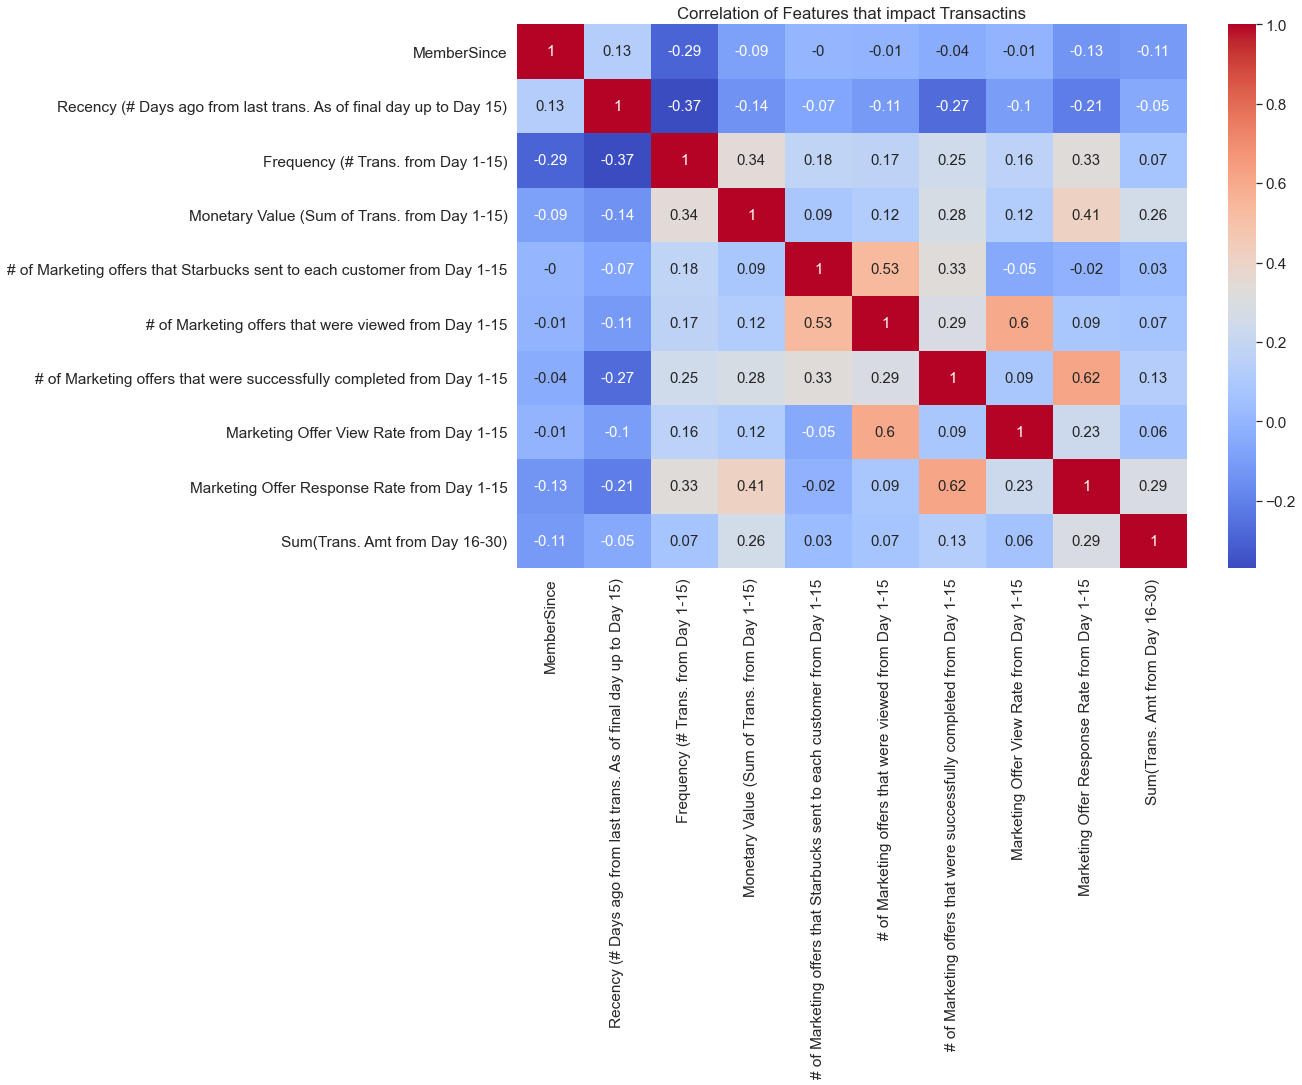

In [18]:
#New Heatmap
plt.figure(figsize = (15,10))
cormap = sbux_clv.corr()
cormap=round(cormap,2)
sns.set(font_scale=1.4)
sns.heatmap(cormap, cmap='coolwarm', annot=True, annot_kws={"size":15})
plt.title('Correlation of Features that impact Transactins')
plt.show()

In [19]:
# Divide customers into CLV quantiles
sbux_clv['CLV_Quantile'] = pd.qcut(sbux_clv['Sum(Trans. Amt from Day 16-30)'], q=5, labels=False)  # Divide into quantiles

# Assign labels to quantiles
quantile_labels = ['Bottom 20%', '20-40%', '40-60%', '60-80%', 'Top 20%']
sbux_clv['CLV_Quantile'] = pd.qcut(sbux_clv['Sum(Trans. Amt from Day 16-30)'], q=5, labels=quantile_labels)

# Print the updated DataFrame
sbux_clv

,Customer ID,Age,Gender,HH Income,MemberSince,Recency (# Days ago from last trans. As of final day up to Day 15),Frequency (# Trans. from Day 1-15),Monetary Value (Sum of Trans. from Day 1-15),# of Marketing offers that Starbucks sent to each customer from Day 1-15,# of Marketing offers that were viewed from Day 1-15,# of Marketing offers that were successfully completed from Day 1-15,Marketing Offer View Rate from Day 1-15,Marketing Offer Response Rate from Day 1-15,Sum(Trans. Amt from Day 16-30),CLV_Quantile
0,0009655768c64bdeb2e877511632db8f,18-34,M,50k-75k,2017,5,1,22.16,2.0,1.0,NaN,0.50,0.00,105.44,Top 20%
1,00116118485d4dfda04fdbaba9a87b5c,Unknown,Unknown,Unknown,2018,2,1,0.70,1.0,1.0,NaN,1.00,0.00,3.39,Bottom 20%
2,0011e0d4e6b944f998e987f904e8c1e5,35-50,O,50k-75k,2018,4,2,25.42,3.0,3.0,1.0,1.00,0.33,54.04,40-60%
3,0020c2b971eb4e9188eac86d93036a77,51-67,F,75k-100k,2016,8,4,98.33,3.0,1.0,1.0,0.33,0.33,98.53,60-80%
4,0020ccbbb6d84e358d3414a3ff76cffd,18-34,F,50k-75k,2016,2,5,62.86,2.0,2.0,1.0,1.00,0.50,91.19,60-80%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15037,fff3ba4757bd42088c044ca26d73817a,68-84,F,75k-100k,2015,1,8,148.84,3.0,2.0,2.0,0.67,0.67,432.14,Top 20%
15038,fff7576017104bcc8677a8d63322b5e1,68-84,M,50k-75k,2017,3,3,16.05,2.0,2.0,1.0,1.00,0.50,13.89,20-40%
15039,fff8957ea8b240a6b5e634b6ee8eafcf,68-84,M,50k-75k,2018,14,1,0.64,NaN,NaN,NaN,NaN,NaN,11.51,20-40%
15040,fffad4f4828548d1b5583907f2e9906b,18-34,M,30k-50k,2017,1,7,42.50,2.0,2.0,1.0,1.00,0.50,46.33,40-60%


In [20]:
def impute_numerical_columns(sbux_clv):
    numerical_columns = sbux_clv.select_dtypes(include=['float64', 'int64']).columns
    sbux_clv[numerical_columns] = sbux_clv[numerical_columns].fillna(0)
    updated_sbux_clv = pd.concat([sbux_clv.select_dtypes(include=['object']), sbux_clv[numerical_columns]], axis=1)
    return sbux_clv

sbux_clv = impute_numerical_columns(sbux_clv)

In [21]:
sbux_clv.to_csv(r'C:\Desktop\sbux_clv_drop_AOV_and_completed_offers_across_channels.csv')

# Calculating the CLV Quantile Means

In [22]:
# Group the data by CLV quantile and calculate median for X variables
grouped_data = sbux_clv.groupby('CLV_Quantile')[['Recency (# Days ago from last trans. As of final day up to Day 15)',
                                                  'Frequency (# Trans. from Day 1-15)',
                                                  'Monetary Value (Sum of Trans. from Day 1-15)',
                                                  '# of Marketing offers that Starbucks sent to each customer from Day 1-15',
                                                  '# of Marketing offers that were viewed from Day 1-15',
                                                  '# of Marketing offers that were successfully completed from Day 1-15',
                                                  'Marketing Offer View Rate from Day 1-15',
                                                  'Marketing Offer Response Rate from Day 1-15']].mean().reset_index()
grouped_data=grouped_data.reset_index()
grouped_data

,index,CLV_Quantile,Recency (# Days ago from last trans. As of final day up to Day 15),Frequency (# Trans. from Day 1-15),Monetary Value (Sum of Trans. from Day 1-15),# of Marketing offers that Starbucks sent to each customer from Day 1-15,# of Marketing offers that were viewed from Day 1-15,# of Marketing offers that were successfully completed from Day 1-15,Marketing Offer View Rate from Day 1-15,Marketing Offer Response Rate from Day 1-15
0,0,Bottom 20%,3.448078,3.086986,10.629747,2.239042,1.417397,0.209373,0.632370,0.094390
1,1,20-40%,3.085049,4.026325,25.588434,2.225785,1.447182,0.463719,0.647081,0.210668
2,2,40-60%,2.906914,4.411467,52.145248,2.268465,1.565261,0.871501,0.682388,0.378708
3,3,60-80%,2.960850,4.058049,72.877978,2.223085,1.596018,1.116774,0.711451,0.497992
4,4,Top 20%,2.675101,4.417004,91.903742,2.314440,1.674426,1.252362,0.716461,0.536758


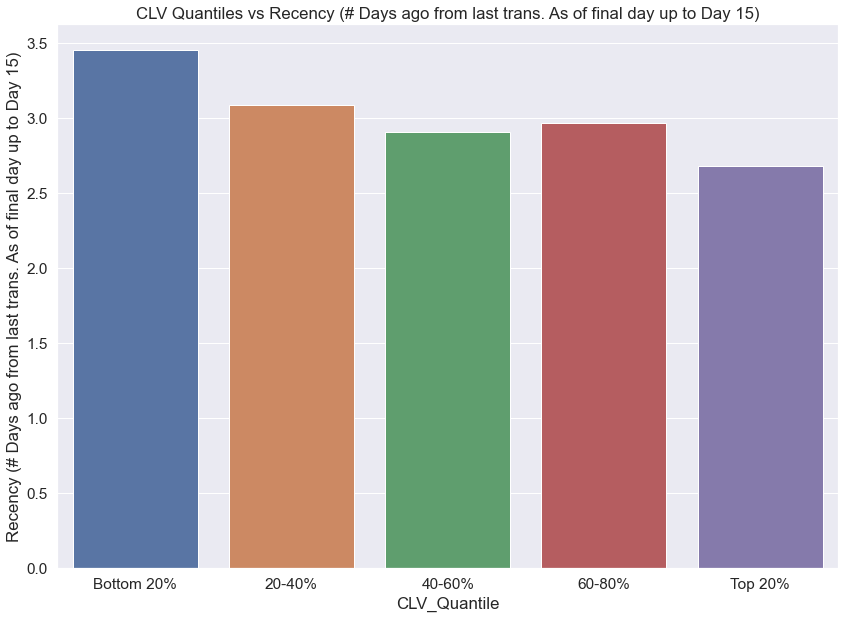

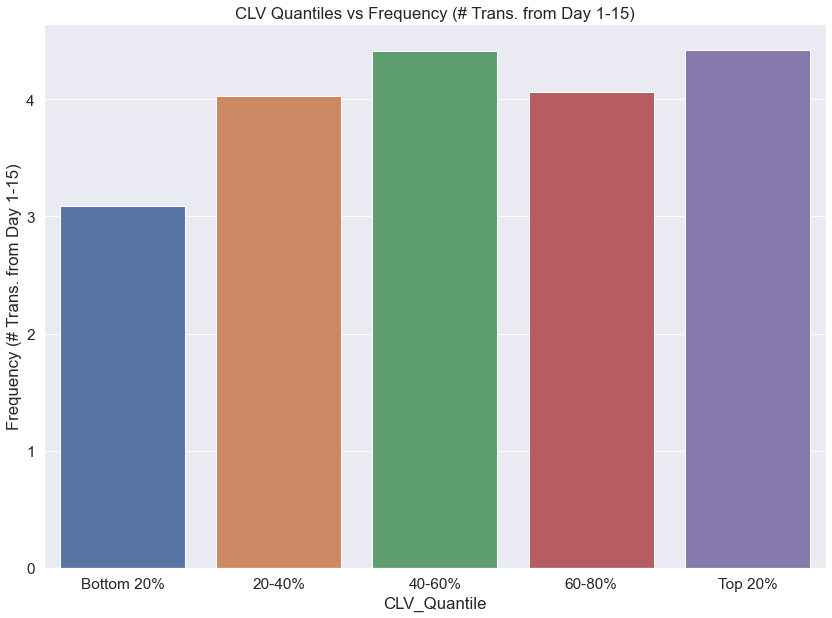

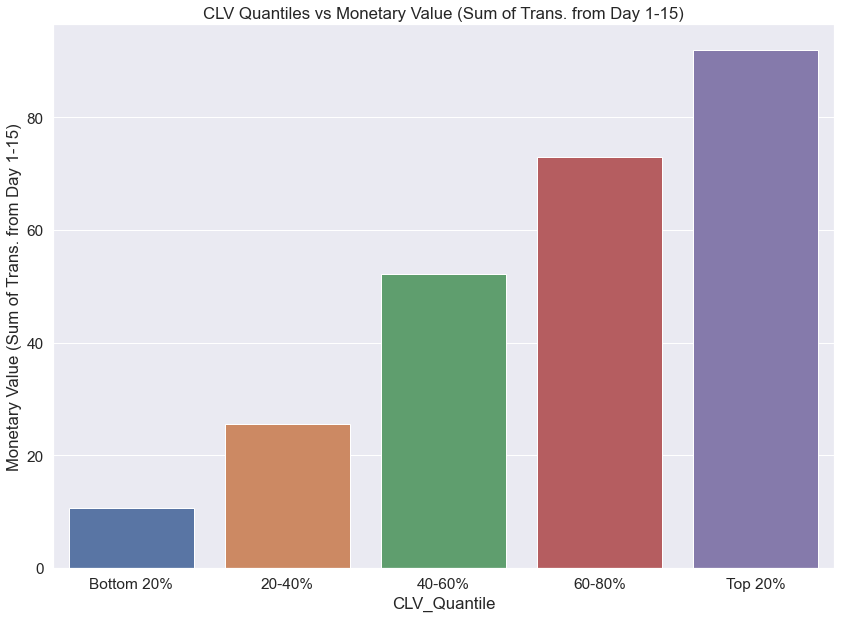

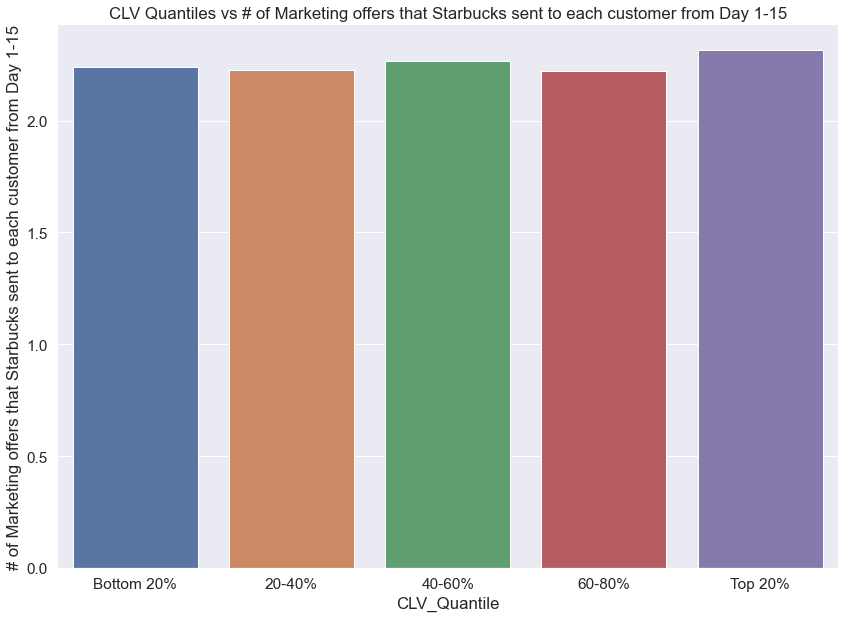

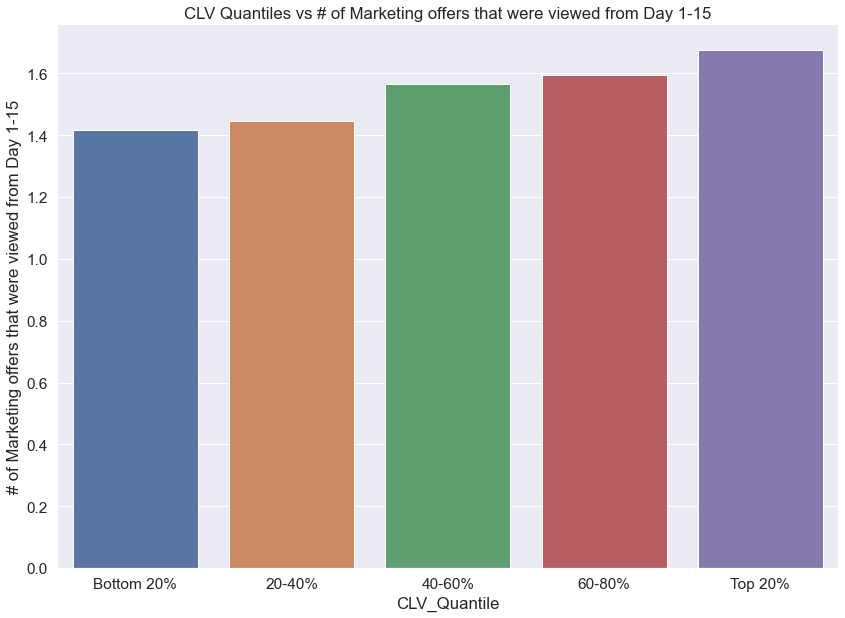

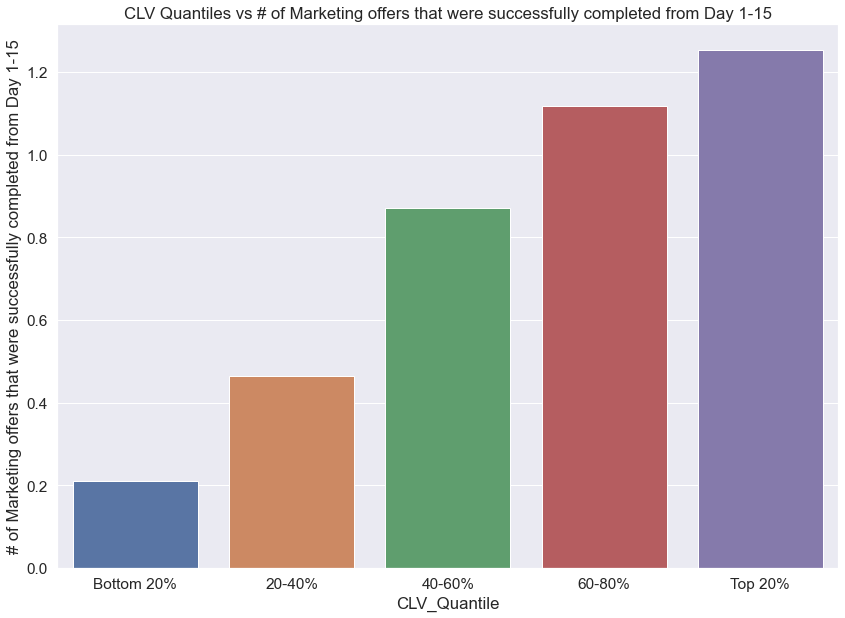

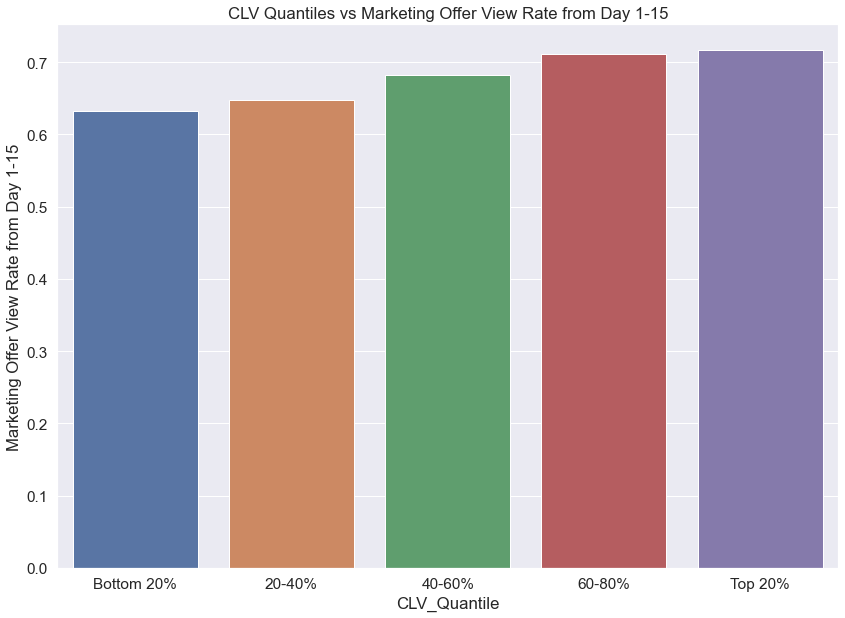

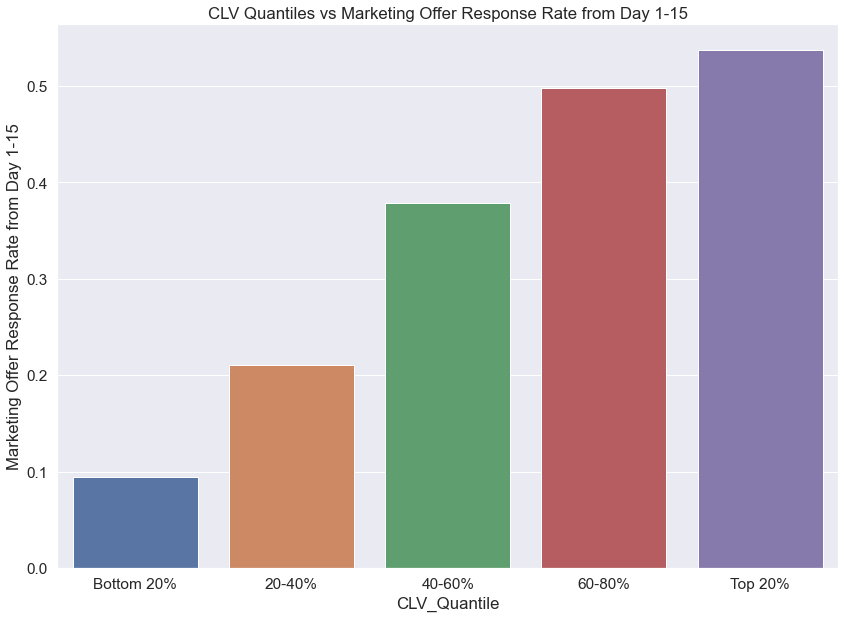

In [23]:
X_Variables = [
    'Recency (# Days ago from last trans. As of final day up to Day 15)',
    'Frequency (# Trans. from Day 1-15)',
    'Monetary Value (Sum of Trans. from Day 1-15)',
    '# of Marketing offers that Starbucks sent to each customer from Day 1-15',
    '# of Marketing offers that were viewed from Day 1-15',
    '# of Marketing offers that were successfully completed from Day 1-15',
    'Marketing Offer View Rate from Day 1-15',
    'Marketing Offer Response Rate from Day 1-15']

for variable in X_Variables:
    plt.figure(figsize=(14, 10)) 
    sns.barplot(x='CLV_Quantile', y=variable, data=grouped_data)
    plt.title(f'CLV Quantiles vs {variable}')
    plt.show()
